# The secular variation of the Earth's magnetic field from observatory data


_Made by Alexandre Fournier (fournier@ipgp.fr), modified by Léonard Seydoux (seydoux@ipgp.fr) in 2023 for the course "Scientific Computing for Geophysical Problems" at the [institut de physique du globe de Paris](http://www.ipgp.fr)._


<img width=200px src="https://upload.wikimedia.org/wikipedia/fr/thumb/1/16/Institut_de_physique_du_globe_de_paris_logo.svg/1200px-Institut_de_physique_du_globe_de_paris_logo.svg.png" />

## Table of contents

1. Introduction
    - 1.1. Goal of the practical
    - 1.2. Theoretical background
2. The forward problem
    - 2.1. The model vector
    - 2.2. The data vector
    - 2.3. The forward matrix
    - 2.4. Implementation of the forward problem
3. The data
    - 3.1. Presentation
    - 3.2. The list of observatories
    - 3.3. The monthly values of the secular variation
4. The inverse problem
    - 4.1. Definition
    - 4.2. The least-squares solution
    - 4.3. The regularized least-squares solution
5. Adding the external field

### 1.1. Goal of the practical

The aim of this practical is to produce an acceptable spherical harmonic representation of the secular variation of the geomagnetic field using records from magnetic observatories for a specified date.

This problem holds both fundamental and practical interest. It's fundamental because the secular variation offers insights into the dynamic processes happening inside the Earth's liquid outer core, where the primary source of the geomagnetic field — the geodynamo — resides. It's practical since understanding the secular variation allows us to predict how the geomagnetic field might change in the near future using simple linear extrapolation.

### 1.2. Theoretical background

The magnetic field ${\mathbf B}$ can be described using a spherical harmonic expansion. This expansion uses Gauss coefficients $g_\ell^m$ and $h_\ell^m$ for the internal field $V_i(r, \theta, \varphi)$, and equivalently denoted $q_\ell^m$ and $s_\ell^m$ for the external field $V_e(r, \theta, \varphi)$, where $\ell$ is the degree and $m$ the order of the spherical harmonic. The total geomagnetic potential $V(r,\theta,\varphi)$ in an insulating region can be written as

$$
V(r,\theta,\varphi) = V_i(r,\theta,\varphi) +  V_e(r,\theta,\varphi), 
$$

with the internal and external potentials given by

$$
\begin{align*}
V_i(r,\theta,\varphi) = &\quad R \sum_{\ell=1}^{L}  \left( \frac{R}{r} \right)^{\ell+1} &\sum_{m=0}^{\ell}  \left( g_\ell^m  \cos m \varphi + h_\ell^m\sin m \varphi \right) {\mathcal P}_\ell^m \left( \cos \theta \right), \\
V_e(r,\theta,\varphi) = &\quad R \sum_{\ell=1}^{L_e} \left( \frac{r}{R} \right)^{\ell} &\sum_{m=0}^{\ell} \left(q_\ell^m \cos m \varphi + s_\ell^m \sin m\varphi \right) {\mathcal P}_\ell^m \left( \cos \theta  \right),
\end{align*}
$$

in which $r$, $\theta$, and $\varphi$ denote the standard spherical coordinates, $R=$ 6371.2 km is the mean radius of the Earth, $L$ is the truncation of the spherical harmonic expansion of the internal sources, and $L_e$ the truncation of the expansion of the external sources. The ${\mathcal P}_\ell^m$ are the associated Legendre functions of degree $\ell$ and order $m$, whose normalization is subject to the Schmidt convention, which is commonly used in geomagnetism. 

Within the insulating region we are focusing on, between the core-mantle boundary and a few tens of km above  the surface of Earth, we have $\mathbf{B} = -\mathbf{\nabla} V$, leading to

$$
\begin{align*}
X &=& -B_\theta &=&\frac{1}{r}\frac{\partial V}{\partial \theta },\\
Y &=& B_\varphi &= &-\frac{1}{r\sin\theta}\frac{\partial V}{\partial \varphi },\\
Z &=& -B_r &= &\frac{\partial V}{\partial r }, 
\end{align*}
$$

where $X$, $Y$ and $Z$ denote the north, east, and vertical components of $\mathbf{B}$, respectively. The time rate-of-change of $\mathbf{B}$, noted $\dot{\mathbf{B}}$, which we are intested in, is therefore controlled by the rate of change of the Gauss coefficients, denoted with $(\dot{g}_\ell^m, \dot{h}_\ell^m)$ and $(\dot{q}_\ell^m, \dot{s}_\ell^m)$  henceforth.

## 2. The forward problem

### 2.1. The model vector

At first, we will neglect the external field and restrict our attention to a model vector consisting of the $(\dot{g}_\ell^m, \dot{h}_\ell^m)$. More precisely, we define the column vector $\mathbf{m}$ with the coefficients of the internal field as

$$
\mathbf{m} \coloneqq \left(\dot{g}_1^0, \dot{g}_1^1, \dot{h}_1^1, \dot{g}_2^0, \dot{g}_2^1, 
                   \dot{h}_2^1, \dot{g}_2^2, \dot{h}_2^2, 
                  \dots, \dot{g}_L^L, \dot{h}_L^L\right)^\mathsf{T}, 
$$

in which $v^\mathsf{T}$ denotes the transpose of the vector $v$. This relatively compact notation aligns with the _International Geomagnetic Reference Field_ (IGRF) convention, as detailed in sources like [this reference paper](https://earth-planets-space.springeropen.com/articles/10.1186/s40623-020-01288-x). We will denote by $M$ the number of elements in the model vector $\mathbf{m}$.

> __Question 1.__ Referring to the previously mentioned equation for the internal potential  $V_i(r, \theta, \varphi)$ given above, how would you determine the number of elements $M$ in the column vector $\mathbf{m}$ based on the expansion truncation index $L$? 
>
> __Answer 1.__ The number of elements in $\mathbf{m}$ is equal to the number of Gauss coefficients, which is equal to $L \left(L+2\right)$. Indeed, we note that we need to store the coefficients $g_\ell^m$ and $h_\ell^m$ for $m=0$ and $m=\ell$ (i.e. $2\ell+1$ coefficients) for each degree $\ell$ from 1 to $L$. The total number of coefficients is therefore equal to
> $$
> \sum_{\ell=1}^{L} 2\ell+1 = L \left(L+2\right).
> $$
> The vector $\mathbf{m}$ is therefore of dimension $L \left(L+2\right)$.

### 2.2. The data vector

The data vector $\mathbf{d}$ is a column vector containing the north, east, and vertical components of the rate-of-change of the field, $\dot{\mathbf{B}}$, at a location. We will denote the components of $\mathbf{d}$ as $\dot{X}$, $\dot{Y}$, and $\dot{Z}$, respectively. The data vector is therefore defined as

$$
\mathbf{d} \coloneqq \left(\dot{X}, \dot{Y}, \dot{Z}\right)^\mathsf{T} \in \mathbb{R}^3.
$$

### 2.3. The forward matrix

The forward problem here refers to the mapping between this set of coefficients and a triplet of measurements of the north, east, or vertical components of the rate-of-change of the field, $\dot{\mathbf{B}}$,  at a location. This can be written in the algebraic form as

$$
\mathbf{d} = \mathbf{A} \mathbf{m} \quad \Longrightarrow \quad
\left( 
\begin{array}{c}
\dot{X} \\
\dot{Y} \\
\dot{Z}
\end{array} \right) 
=
\left( 
\begin{array}{c}
\mathbf{A}_X  \\
\mathbf{A}_Y  \\
\mathbf{A}_Z
\end{array}
\right) \mathbf{m},  
$$

where each row ($\mathbf{A}_X$,  $\mathbf{A}_Y$ and $\mathbf{A}_Z$) of the matrix $\mathbf{A}$ (hereafter referred to as the _forward matrix_) corresponds to the mapping between the model vector $\mathbf{m}$ and the data vector $\mathbf{d}$ for each component of the field. It has the same dimension as $\mathbf{m}$, and is a function of the observation location $(r_\mathrm{obs}, \theta_\mathrm{obs}, \varphi_\mathrm{obs})$ defined the observatory's location. The problem can be written this way because the problem is a linear one.



### 2.4. Implementation of the forward problem for a single component

The Python module `geomag.py` comprises a series of functions that return ($\mathbf{A}_X$,  $\mathbf{A}_Y$ or $\mathbf{A}_Z$), provided you feed them with a location in spherical coordinates $(r, \theta, \varphi)$ with the radius $r\in ]0, +\inf[$ in km, the colatitude $\theta \in [0, 180]$ and the longitude $\varphi \in [0, 360]$ in degrees. For example, the piece of code below shows how the `forward_matrix` function can be used to map a user-defined $\mathbf{m}$ into a global map of the secular variation over a regular grid at radius $r=R$. 

_Prior to going further, make sure that the imports below work on your computer._

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geomag

We will evaluate this function on a regular grid of points on the surface of the Earth, and plot the results using the `matplotlib` library. This can be done using the `np.meshgrid` function, as shown below.

In [25]:
# Create colatitude and longitude arrays for a grid of points
# over the surface of the Earth.
GRID_RESOLUTION_IN_DEGREES = 3
colatitude = np.arange(1, 180, GRID_RESOLUTION_IN_DEGREES)
longitude = np.arange(0, 360, GRID_RESOLUTION_IN_DEGREES)
n_colatitudes = len(colatitude)
n_longitudes = len(longitude)
radius = 6371.2

# Turn into grid
longitudes, colatitudes = np.meshgrid(longitude, colatitude)
radii = radius * np.ones_like(colatitudes)

# Flatten the arrays
grid = np.vstack(
    (radii.flatten(), colatitudes.flatten(), longitudes.flatten())
).T
n_points = grid.shape[0]

Once we have a regular grid of points, we can evaluate the forward problem at each point of the grid. This is done using the `forward_matrix` function, which returns the three components of the field at a given location, given a set of Gauss coefficients, and for a given component (`X`, `Y`, or `Z`). Note that the function is NOT vectorized, meaning that it can only be used to evaluate the field at one location at a time. This is why we need to loop over the grid points to evaluate the field at each point.

Note that the forward problem here reduces to the computation of a single component, meaning that we will calculate only $\dot{Z}$ such as 

$$
\dot{Z} = \mathbf{A}_Z \mathbf{m}.
$$

In [26]:
# Get the forward matrix for each point in the grid
forward_matrix = np.zeros((n_points, geomag.N_COEFFICIENTS))
for index, point in enumerate(grid):
    forward_matrix[index, :] = geomag.forward_matrix(*point, component="z")

print("Number of points in grid:", n_points)
print("Number of coefficients:", geomag.N_COEFFICIENTS)
print("Shape of forward matrix:", forward_matrix.shape)

Number of points in grid: 7200
Number of coefficients: 80
Shape of forward matrix: (7200, 80)


Now, we can use the forward matrix to evaluate the field at each point of the grid. We therefore need to define a model vector $\mathbf{m}$ and apply the forward matrix to it to obtain the field at each point of the grid. The code below shows how this can be done.

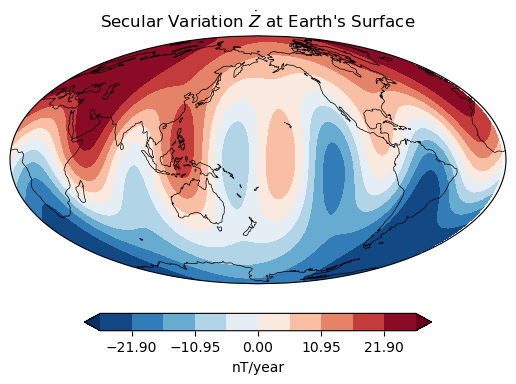

In [27]:
# Define the model vector
model = np.zeros(geomag.N_COEFFICIENTS)
lm = -1
for l in range(1, geomag.MAX_DEGREE + 1):
    for m in range(0, l + 1):
        if m == 0:
            lm = lm + 1
            if l == 1:
                # Axial dipole
                model[lm] = -10
        elif m > 0:
            lm = lm + 1

            # Get the g
            if l == 2 and m == 1:
                model[lm] = -4
            lm = lm + 1

            # Get the h
            if l == 1 and m == 1:  
                # Equatorial dipole
                model[lm] = -4
            if l == 5 and m == 5:
                model[lm] = 3

# Compute the forward model
data = np.dot(forward_matrix, model)

# Plot
ax = geomag.plot_field(colatitude, longitude, data)
ax.set_title("Secular Variation $\dot Z$ at Earth's Surface")

# Show
plt.show()

Now we can explore the possibilities of the function `forward_matrix` by looking at other components of the field. First, take a look at the documentation of the function `forward_matrix`. You can do it either by running `?forward_matrix` in a cell, or by looking at the source code of the function in the `geomag.py` file.

> **Question 2.** In the cell below, create a new code inspired from the cells above to plot the north component of the secular variation $\dot{X}$ at the surface of the Earth for the same model vector $\mathbf{m}$.

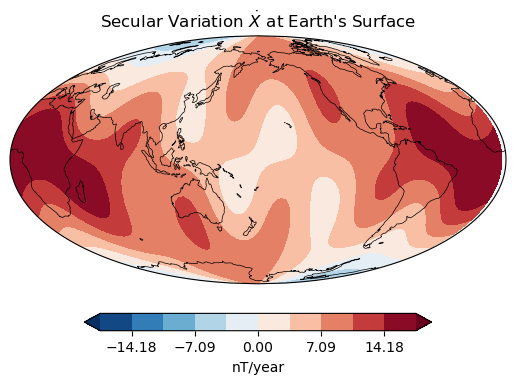

In [28]:
# Forward matrix
forward_matrix = np.zeros_like(forward_matrix)
for index, point in enumerate(grid):
    forward_matrix[index, :] = geomag.forward_matrix(*point, component="x")

# Compute the forward model
data = np.dot(forward_matrix, model)

# Plot
ax = geomag.plot_field(colatitude, longitude, data)
ax.set_title("Secular Variation $\dot X$ at Earth's Surface")

# Show
plt.show()



> **Question 3.** Thanks to your newly acquired expertise, create a new code inspired from the cells above to plot the vertical component of the secular variation $\dot{X}$ at the surface of the core for the same model vector $\mathbf{m}$. Take the radius of the core equal to $3485$ km. What do you observe, and why?
> 
> **Answer 3.** We see that the closer we get to the source of the magnetic field (the geodynamo), the shorter the wavelength of the variations is. This is consistent with the spherical harmonic representation of the internal magnetic field as the amplitude of the component of degree $\ell$ decreases as 
>$$1/r^{(\ell+2)}$$
> and higher degrees correspond to shorter wavelengths. Therefore, at the Earth's surface, we only see long wavelengths while at the core surface we are able to see smaller details carried by harmonic of higher degrees.

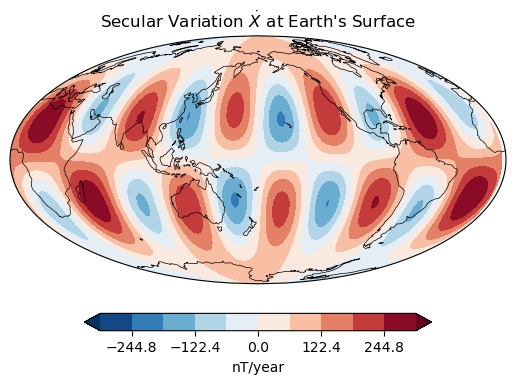

In [29]:
radius_core = 3485. * np.ones_like(colatitudes)
grid_core = np.vstack(
    (radius_core.flatten(), colatitudes.flatten(), longitudes.flatten())
).T

# Forward matrix
forward_matrix = np.zeros_like(forward_matrix)
for index, point in enumerate(grid_core):
    forward_matrix[index, :] = geomag.forward_matrix(*point, component="x")

# Compute the forward model
data = np.dot(forward_matrix, model)

# Plot
ax = geomag.plot_field(colatitude, longitude, data)
ax.set_title("Secular Variation $\dot X$ at Earth's Surface")

# Show
plt.show()

> **Question 4:**  In the cell below, insert a piece of code that calculates and plots $\dot{X}$, $\dot{Y}$ and $\dot{Z}$ at the Earth's surface for an axial quadrupole $\dot{g}_2^0=$ -3 nT/year, with all other coefficients being $0$.
We will refer to this model vector $\mathbf{m}$ as $\mathbf{m}_g$ in the following.

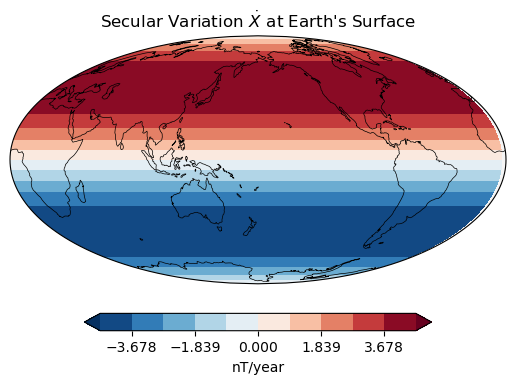

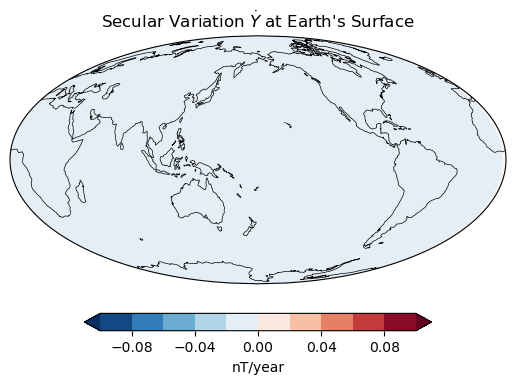

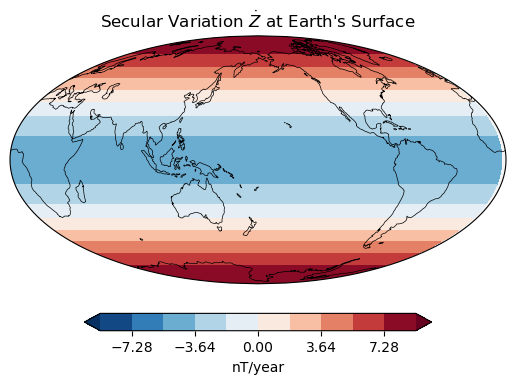

In [30]:
# Define the model vector mg
model_g = np.zeros(geomag.N_COEFFICIENTS)
model_g[3] = -3

# Loop over components
components = ["x", "y", "z"]
for component in components:
    # Forward matrix
    forward_matrix = np.zeros_like(forward_matrix)
    for index, point in enumerate(grid):
        forward_matrix[index, :] = geomag.forward_matrix(*point, component=component)

    # Compute the forward model
    data = np.dot(forward_matrix, model_g)

    # Plot
    ax = geomag.plot_field(colatitude, longitude, data)
    ax.set_title(f"Secular Variation $\dot {component.upper()}$ at Earth's Surface")

    # Show
    plt.show()

## 3. The data

### 3.1. Presentation

The monthly values of $\dot{X}$, $\dot{Y}$ and $\dot{Z}$ have been compiled in [Wardinski et al. (2012)](https://academic.oup.com/gji/article/189/3/1409/610042) for a number of observatories, between years 1957 and 2013 (approximately). Note that not all observatories have continuous records: some records are actually very sparse in time.

### 3.2. The list of observatories

The file `data/observatories.txt` contains information about the observatories. The first row of this file indicates the title of each column. The columns are:

- `index`: the observatory index, ranging from 1 to the total number of observatories
- `code`: the observatory code, as a 3-letter string which correspond to a place on Earth (e.g. `ESK` for Eskdalemuir, UK)
- `colatitude`: the colatitude of the observatory in degrees, ranging from 0 to 180
- `longitude`: the longitude of the observatory in degrees, ranging from 0 to 360
- `radius`: the elevation of the observatory in km

> __Question 5.__ In the cell below, read the file `data/observatories.txt` and store the content of the file in a variable named `observatories`. You can use either the Numpy or the Pandas package to do so. Beforehand, be aware of the delimiter used in the file (comma, space, tab, etc.). Display a map of the observatories using the `plot_locations` function defined in the `geomag.py` module. Please check the documentation of this function to see how to use it.  What is the total number of observatories in the database? What is the three-letter code of the observatory located at the highest elevation? And the position?
> 
> __Answer 5.__ The total number of observatories is 323. The observatory with the highest elevation is named `HUA`, with an elevation of 9.33 km above the Earth's mean radius. It is shown with an orange dot on the map below.

The database contains 323 observatories.
The highest observatory is HUA located at a radius of 9.33 km.


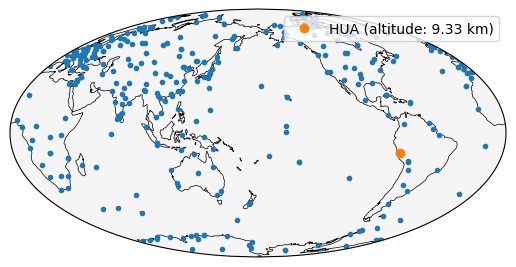

In [31]:
# Read the file
observatories = pd.read_csv("data/observatories.txt", sep=" ", index_col=0)

# Get highest observatory
highest = observatories.sort_values("radius", ascending=False).iloc[0]
highest_elevation = highest["radius"] - geomag.EARTH_RADIUS_KM
print(f"The database contains {len(observatories)} observatories.")
print(f"The highest observatory is {highest.code} located at a radius of {highest_elevation:0.2f} km.")

# Plot the observatories on the map
ax = geomag.plot(
    observatories.colatitude,
    observatories.longitude,
    marker=".",
    linestyle="none",
)

# Plot the highest observatory
geomag.plot(
    highest.colatitude,
    highest.longitude,
    marker="o",
    linestyle="none",
    ax=ax,
    label=f"{highest.code} (altitude: {highest_elevation:0.2f} km)",
)

# Add a legend
ax.legend(loc="upper right")

# Show
plt.show()

### 3.3. The monthly values of the secular variation

The file `data/monthly_mean_secular_variation.in` contains the monthly values of $\dot{X}$, $\dot{Y}$ and $\dot{Z}$ for each observatory. The first row of this file indicates the title of each column. The columns are:

- `index`: the observatory index
- `year`: the decimal year of the measurement
- `colatitude`: the colatitude of the observatory in degrees
- `longitude`: the longitude of the observatory in degrees
- `radius`: the elevation of the observatory in km
- `x_dot`: the north component of the secular variation in nT/year
- `y_dot`: the east component of the secular variation in nT/year
- `z_dot`: the vertical component of the secular variation in nT/year

> __Question 6.__ Read the file `data/monthly_mean_secular_variation.in` and store the content of the file in a variable named `observations`. You can use either the Numpy or the Pandas package to do so. Select the observatory which code is `NGK` and plot the observed secular variation of the geomagnetic field at this location. You should observe that the secular variation is sort of piecewise linear with an abrupt change in 1970 called a _geomagnetic churk_. These changes reflect waves propagating in the core submitted to the Coriolis and Lorentz forces.

Observatory: NGK
Observatory index: 34
Number of data points: 675


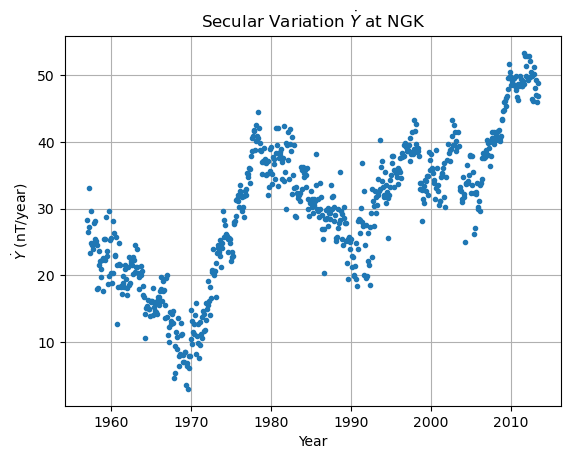

In [32]:
OBSERVATORY = "NGK"

# Read the observatory data
filename = "data/monthly_mean_secular_variation.in"
observations = pd.read_csv(filename, sep=" ", index_col=0)

# Get the index of the observatory
observatory_index = observatories[observatories.code == OBSERVATORY].index[0]

# Get the data for the observatory
data = observations[observations.index == observatory_index]

# Display basic information
print(f"Observatory: {OBSERVATORY}")
print(f"Observatory index: {observatory_index}")
print(f"Number of data points: {data.shape[0]}")

# Plot
ax = data.plot("year", "y_dot", style=".", legend=False, grid=True)
ax.set_title(f"Secular Variation $\dot Y$ at {OBSERVATORY}")
ax.set_ylabel(r"$\dot{Y}$ (nT/year)")
ax.set_xlabel("Year")
plt.show()

> __Question 7.__ Write a function that collects all the available data measurements at a given date (with a user-defined tolerance). For instance, consider the date 1974.67 with a tolerance of $\pm$ one week. Show a map with all working observatories at that date. How many observatories are working at that date? Bonus: using the `geomag.scatter` function, plot the secular variation at each observatory at that date.
>
> **Answer 7.** There are 169 observatories working at the date 1974.67 with a tolerance of $\pm$ one week. The map below shows the location of these observatories. The scatter plot shows the secular variation at each observatory at that date.

Year: 1991
Number of observations: 169


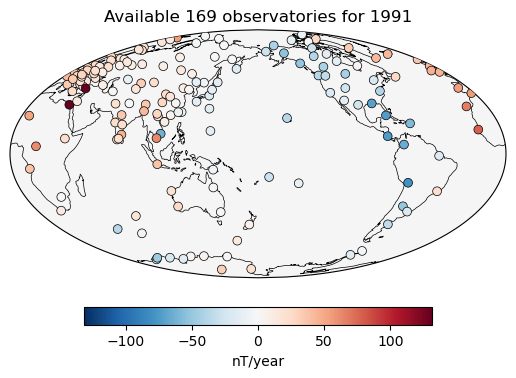

In [33]:
YEAR = 1991
TOLERANCE = 1 / 52

# Get the data for the observatory
mask = np.abs(observations.year - YEAR) < TOLERANCE
data = observations[mask]

# Get the corresponding observatories
working_observatories = observatories.loc[data.index]

# Display basic information
print(f"Year: {YEAR}")
print(f"Number of observations: {data.shape[0]}")


# Plot the values of the secular variation
vmax = 0.3 * np.abs(data.y_dot).max()
ax = geomag.scatter(
    working_observatories.colatitude,
    working_observatories.longitude,
    c=data.y_dot,
    s=40,
    linewidths=0.5,
    edgecolors="k",
    zorder=10,
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
)

 
# Label the observatories
ax.set_title(f"Available {data.shape[0]} observatories for {YEAR}")

# Show
plt.show()

## 4. The inverse problem

### 4.1. Definition

Given the observation vector $\mathbf{d}$ that you can collect at a given date, your goal is first to seek the optimal model $\mathbf{m}^*$ that will minimize the quadratic functional $J(\mathbf{m})$ defined as

$$
J(\mathbf{m}) = (\mathbf{d}-\mathbf{A}\mathbf{m})^\mathsf{T} \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}), 
$$

that quantifies the departure from predictions made with the model from the actual observations. The weight matrix $\mathbf{W}$ reflects the uncertainties affecting each datum. The matrix $\mathbf{W}$ can be defined manually using the `weights_matrix` function of the `geomag.py` module. This matrix is diagonal and each of its diagonal element is equal to $1/\sigma^2$ where $\sigma$ is the standard deviation reflecting the uncertainty in the datum (its variance is therefore equal to $\sigma^2$). For a start, we will take the same value for each datum, $\sigma=1$ nT/yr.

### 4.2. First attempt

> __Question 9.__ Assemble the data vector for an epoch of your choice. What dimension does it have? Define the weight matrix $\mathbf{W}$ and the matrix $\mathbf{A}$ for the same epoch. What dimension do they have? 
> 
> __Answer 9.__ The data vector $\mathbf{d}$ for the date 1975 $\pm$ one week contains 158 observatories. It means that the entire data vector $\mathbf{d}$ is of dimension $3 \times 158 = 474$. The weight matrix $\mathbf{W}$ is a diagonal matrix of dimension $474 \times 474$. The matrix $\mathbf{A}$ is of dimension $474 \times L(L+2)$. 

In [34]:
YEAR = 1975
TOLERANCE = 1 / 52

# Get the data for the observatory
mask = np.abs(observations.year - YEAR) < TOLERANCE
data = observations[mask]

# Define the design matrix
forward = np.zeros((3, len(data), geomag.N_COEFFICIENTS))
for index, (_, datum) in enumerate(data.iterrows()):
    point = datum.radius, datum.colatitude, datum.longitude
    forward[:, index] = geomag.forward_matrix(*point, component="all")

# Reshape the design matrix
forward = forward.reshape((3 * len(data), geomag.N_COEFFICIENTS))
observation = np.hstack((data.x_dot, data.y_dot, data.z_dot))
weight = geomag.weights_matrix(len(observation), 1)

# Display basic information
print(f"Observation vector shape: {observation.shape}")
print(f"Forward matrix shape: {forward.shape}")

Observation vector shape: (474,)
Forward matrix shape: (474, 80)


> __Question 10.__ We can now evaluate the residuals with a first attempt (naive) by considering the model vector $\mathbf{m}_g$ defined in Question 4.  The residuals are defined as
> $$
> \mathbf{r} = \mathbf{d} - \mathbf{A}\mathbf{m}_g,
> $$
> and also evaluate the cost $J(\mathbf{m}_g)$ from the original expression of this functionnal given above. What dimension does the residual vector $\mathbf{r}$ have? What dimension does the cost $J(\mathbf{m}_g)$ have?
>
> __Answer 10.__  The residuals are the difference between the data vector $\mathbf{d}$ and the predicted data vector $\mathbf{A}\mathbf{m}_g$ and are equal to a vector of dimension $474 \times 1$. The cost $J(\mathbf{m}_g)$ is a scalar. When considering the secular variation at the year 1975, we obtain a cost of $780 \times 10^3$ nT/year.

In [35]:
model = np.zeros(geomag.N_COEFFICIENTS)
model[3] = -3

# Solve the inverse problem
residuals = observation - np.dot(forward, model)
cost = residuals.dot(weight).dot(residuals)

# Display basic information
print(f"Residuals shape: {residuals.shape}")
print(f"J(m) = {cost:,.2f} nT")

Residuals shape: (474,)
J(m) = 780,953.34 nT


> __Question 11.__ We note that the residuals are obtained for every components of the field. We can also look at the residuals for each component separately. In the cell below, write a code that allows you to compute the residuals for each component of the field separately, and for all components at once. What is the cost for each component of the field? What is the total cost? What do you observe?
>
> __Answer 11.__ The overall residuals are about $780 \times 10^3$ nT/year, however, the residuals for the vertical component are much larger than the residuals for the horizontal components.

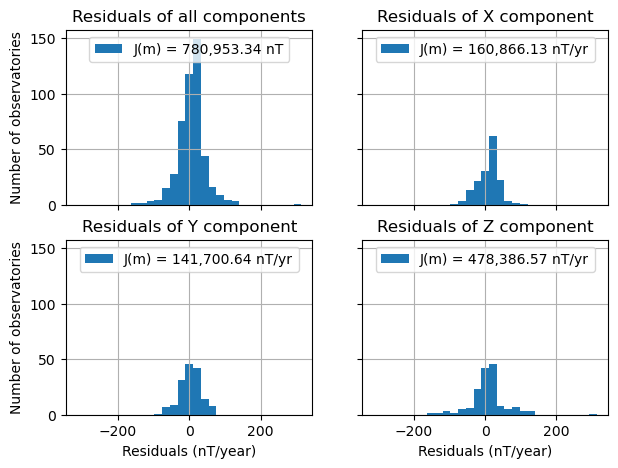

In [36]:
# Prepare the bins
residuals_max = np.abs(residuals).max()
bins = np.linspace(-residuals_max, residuals_max, 30)

# Prepare the figure
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7, 5))
ax = ax.flatten()

# Plot the residuals of all components
ax[0].hist(residuals, bins=bins)
ax[0].grid(True)
ax[0].legend([f"J(m) = {cost:,.2f} nT"], loc="upper center")
ax[0].set_title("Residuals of all components")
ax[0].set_ylabel("Number of observatories")
ax[2].set_ylabel("Number of observatories")
ax[2].set_xlabel("Residuals (nT/year)")
ax[3].set_xlabel("Residuals (nT/year)")

# Plot the residuals of every component
residuals_components = residuals.reshape((len(data), 3))
for index, component in enumerate("xyz"):

    # Compute inverse problem
    a = np.zeros((len(data), geomag.N_COEFFICIENTS))
    for i, (_, datum) in enumerate(data.iterrows()):
        point = datum.radius, datum.colatitude, datum.longitude
        a[i] = geomag.forward_matrix(*point, component=component)
    d = data[f"{component}_dot"]
    r = d - np.dot(a, model)
    w = geomag.weights_matrix(len(d), 1)
    j = r.dot(w).dot(r)

    ax[index + 1].hist(r, bins=bins)
    ax[index + 1].set_title(f"Residuals of {component.upper()} component")
    ax[index + 1].grid(True)
    ax[index + 1].legend([f"J(m) = {j:,.2f} nT/yr"], loc="upper center")
plt.show()

### 4.3. The least-squares solution

The optimal model $\mathbf{m}^*$ is the one that minimizes the quadratic functional $J(\mathbf{m})$. In other words, it is the one that satisfies the following equation:

$$
\left. \frac{\partial J}{\partial \mathbf{m}} \right|_{\mathbf{m}=\mathbf{m}^*} = 0.
$$ 

> __Question 12.__ We consider the truncation degree for the internal field equal $L=$ 8. Is the problem you are looking at over- or under-determined? If it is under-determined, consider changing the epoch to collect more data points. Next, derive the algebraic expression of $\mathbf{m}^*$, and write a code in the cell below to compute $J(\mathbf{m}^*)$.
>
> __Answer 12.__ We recall the expression of the functional $J(\mathbf{m})$:
> 
> $$
> J(\mathbf{m}) = (\mathbf{d}-\mathbf{A}\mathbf{m})^\mathsf{T} \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}),
> $$
> 
> where $\mathbf{d}$ is the data vector, $\mathbf{A}$ is the forward matrix, and $\mathbf{W}$ is the weight matrix. The optimal model $\mathbf{m}^*$ is the one that minimizes the quadratic functional $J(\mathbf{m})$. In other words, it is the one that > satisfies the following equation:
> 
> $$
> \left. \frac{\partial J}{\partial \mathbf{m}} \right|_{\mathbf{m}=\mathbf{m}^*} = 0.
> $$
> 
> First, we expand the quadratic form:
> 
> $$
> \begin{align*}
> J(\mathbf{m}) &= (\mathbf{d}-\mathbf{A}\mathbf{m})^\mathsf{T} \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}) \\
&= (\mathbf{d}^\mathsf{T}-\mathbf{m}^\mathsf{T}\mathbf{A}^\mathsf{T}) \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}) \\
&= \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{d} - \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m} - \mathbf{m}^\mathsf{T}\mathbf
{A}^\mathsf{T}\mathbf{W}\mathbf{d} + \mathbf{m}^\mathsf{T}\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m} \\
&= \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{d} - 2\mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m} + \mathbf{m}^\mathsf{T}\mathbf
{A}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m}.
> \end{align*}
> $$
> 
> Then, we compute the derivative of $J(\mathbf{m})$ with respect to $\mathbf{m}$:
> 
> $$
> \begin{align*}
\frac{\partial J}{\partial \mathbf{m}} &= -2\mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A} + 2\mathbf{m}^\mathsf{T}\mathbf{A}^\mathsf{T}> \mathbf{W}\mathbf{A} \\
> &= -2\mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A} + 2\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} \mathbf{m}\\
> \end{align*}
> $$
> 
> Finally, we set the derivative to zero and solve for $\mathbf{m}$:
> 
> $$
> \begin{align*}
\left. \frac{\partial J}{\partial \mathbf{m}}\right|_{\mathbf{m} = \mathbf{m}^*} = 0 & \quad\Rightarrow\quad -2\mathbf{d}^\mathsf> {T}\mathbf{W}\mathbf{A} + 2\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} \mathbf{m}^* = 0 \\
 & \quad\Rightarrow\quad \mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} \mathbf{m}^* = \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A} \\
 & \quad\Rightarrow\quad \mathbf{m}^* = \left(\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A}\right)^{-1} \mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{d}.
> \end{align*}
> $$

Cost function (least squares): 159,011.57 nT


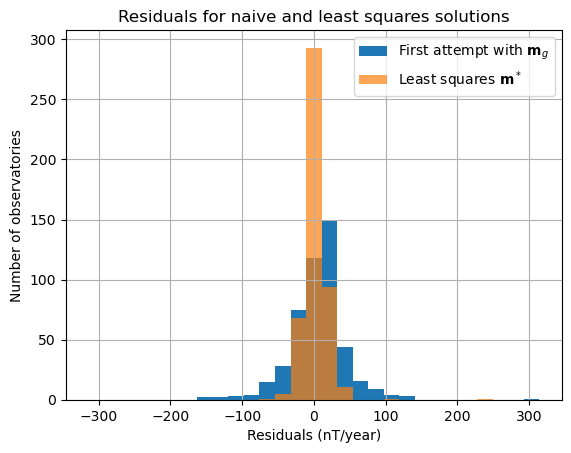

In [37]:
# Define the matrix aTwa
weighted_forward_matrix = forward.T.dot(weight).dot(forward)

# Invert it
inverse_weighted_forward_matrix = np.linalg.inv(weighted_forward_matrix)

# Compute the least squares solution
model_least_squares = (
    inverse_weighted_forward_matrix.dot(forward.T)
    .dot(weight)
    .dot(observation)
)

# Compute the residuals and the cost function
residuals_least_squares = observation - forward.dot(model_least_squares)
mistfit = residuals_least_squares.T.dot(weight).dot(residuals_least_squares)

# Plot residuals
fig, ax = plt.subplots(1)
ax.hist(residuals, bins=bins, label="First attempt with $\mathbf{m}_g$")
ax.hist(residuals_least_squares, bins=bins, alpha=0.7, label="Least squares $\mathbf{m}^*$")
ax.set_xlabel("Residuals (nT/year)")
ax.set_ylabel("Number of observatories")
ax.legend()
ax.grid()
ax.set_title("Residuals for naive and least squares solutions")

# Print cost function value
print(f"Cost function (least squares): {mistfit:,.2f} nT")

> **Question 13.** Based on the set of example codes that you already wrote and executed, plot the correspond $\dot{Z}$ at the surface of the Earth and at the surface of the core ($r=3485$ km) by evaluating the forward matrix at the optimal model $\mathbf{m}^*$ you just computed for each point of the regular grid. 

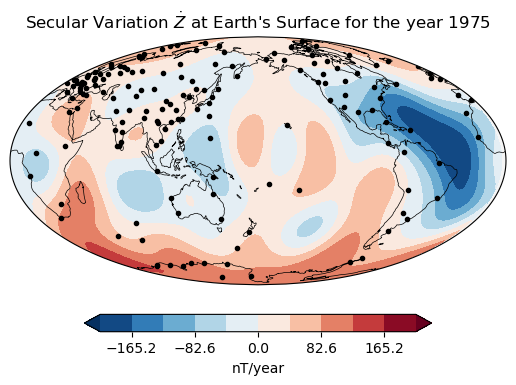

In [38]:
# Forward matrix
forward_matrix = np.zeros((n_points, geomag.N_COEFFICIENTS))
for index, point in enumerate(grid):
    forward_matrix[index] = geomag.forward_matrix(*point, component="z")

# Compute the forward model
field = np.dot(forward_matrix, model_least_squares)

# Plot
ax = geomag.plot_field(colatitude, longitude, field)
geomag.plot(
    working_observatories.colatitude,
    working_observatories.longitude,
    ax=ax,
    marker=".",
    color="k",
    linestyle="none",
)
ax.set_title("Secular Variation $\dot Z$ at Earth's Surface for the year 1975")

# Show
plt.show()

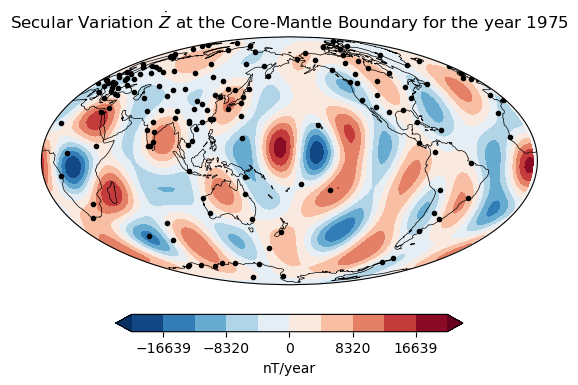

In [39]:
# Forward matrix
forward_matrix = np.zeros((n_points, geomag.N_COEFFICIENTS))
for index, point in enumerate(grid_core):
    forward_matrix[index] = geomag.forward_matrix(*point, component="z")

# Compute the forward model
field = np.dot(forward_matrix, model_least_squares)

# Plot
ax = geomag.plot_field(colatitude, longitude, field)
geomag.plot(
    working_observatories.colatitude,
    working_observatories.longitude,
    ax=ax,
    marker=".",
    color="k",
    linestyle="none",
)
ax.set_title("Secular Variation $\dot Z$ at the Core-Mantle Boundary for the year 1975")

# Show
plt.show()

> **Question 14:** Comment on the aspects of  $\dot{Z}$ at the surface of the core.
> 
> **Answer 14.** As discussed earlier, we see that the magnitude of $\dot{Z}$ and the wavelength of its variations of at the surface of the core are stronger and shorter, repsectively, than at the surface of the Earth. However, the main patterns are visible both on the prediction at the surface of the core and at the surface of the Earth. Considering the spatial distribution of the observatories, our prediction is less constrained on oceans than on continents and also less constrained in the southern hemisphere than in the northern one. We cannot be very confident in the extent of the anomalies in the middle of the Pacific ocean as they are only constrained by three observatories separated by several thousands of kilometres.

> **Question 15:** Compute the residuals and analyze their distribution, on a component-by-component basis $(\dot{X}, \dot{Y}, \dot{Z})$. Which component appears to be the most challenging to model using our current strategy?
> 
> **Answer 15.** The vertical component of the secular variation $\dot{\mathbf{Z}}$ seems to be the most challenging to model as shown by the component-wise residuals below. The $X$ component is also hard to model as the distribution of the associated residuals is not centered on 0.

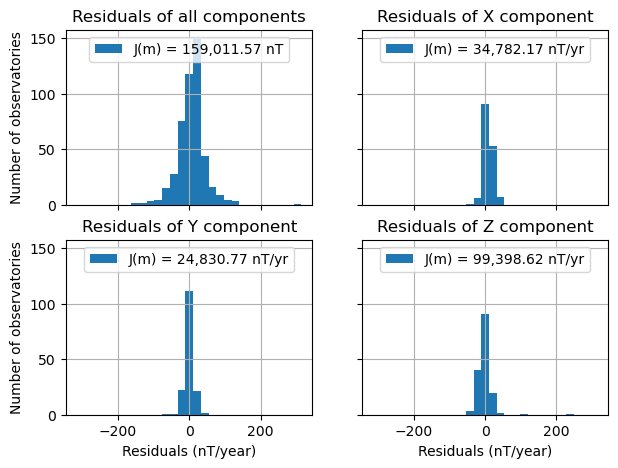

In [40]:
# Prepare the bins
residuals_max = np.abs(residuals).max()
bins = np.linspace(-residuals_max, residuals_max, 30)

# Prepare the figure
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7, 5))
ax = ax.flatten()

# Plot the residuals of all components
ax[0].hist(residuals, bins=bins)
ax[0].grid(True)
ax[0].legend([f"J(m) = {mistfit:,.2f} nT"], loc="upper center")
ax[0].set_title("Residuals of all components")
ax[0].set_ylabel("Number of observatories")
ax[2].set_ylabel("Number of observatories")
ax[2].set_xlabel("Residuals (nT/year)")
ax[3].set_xlabel("Residuals (nT/year)")

# Plot the residuals of every component
for index, component in enumerate("xyz"):

    # Compute inverse problem
    w = geomag.weights_matrix(len(d), 1)
    a = np.zeros((len(data), geomag.N_COEFFICIENTS))
    for i, (_, datum) in enumerate(data.iterrows()):
        point = datum.radius, datum.colatitude, datum.longitude
        a[i] = geomag.forward_matrix(*point, component=component)
    d = data[f"{component}_dot"]
    r = d - np.dot(a, model_least_squares)
    j = r.dot(w).dot(r)

    ax[index + 1].hist(r, bins=bins)
    ax[index + 1].set_title(f"Residuals of {component.upper()} component")
    ax[index + 1].grid(True)
    ax[index + 1].legend([f"J(m) = {j:,.2f} nT/yr"], loc="upper center")
plt.show()

### 4.4. The regularized least-squares solution

We now seek a regularized solution to the problem at hand. This is a standard approach followed in geophysics. The squared norm of the secular variation noted $\mathcal R$ over a sphere $\mathcal{S}(r)$ of radius $r$ is defined as 

$$
\mathcal R = \int_{S(r)} \|\dot{\mathbf{B}}\|^2 {\mathrm d} \Omega
$$

This quantity can be conveniently expressed using the Gauss coefficients (see for instance the reference book "Foundations of Geomagnetism" by Backus et al. 1996 Cambridge University, ISBN 9780521410069) as follows:

$$
\mathcal R = \sum_{\ell=1}^L \left(\ell+1\right) \left(\frac{a}{r} \right)^{2\ell+4} \sum_{m=0}^{\ell}
              \left[(\dot{g}_\ell^m)^2+(\dot{h}_\ell^m)^2\right] = \sum_{\ell = 1}^L \mathcal R_{\ell},
$$

where the last part shows that the norm is the sum of the norm of each spherical harmonic component $\mathcal R_{\ell}$, where $\ell$ is the degree of the harmonic, and the expression of $\mathcal R_{\ell}$ is given by
$$
\mathcal R_{\ell} = \left(\ell+1\right) \left(\frac{a}{r} \right)^{2\ell+4} \sum_{m=0}^{\ell}
              \left[(\dot{g}_\ell^m)^2+(\dot{h}_\ell^m)^2\right]
$$

In algebraic form, this can be written directly with the following matrix product:

$$
\mathcal R = \mathbf{m}^\mathsf{T} \mathbf{D} \mathbf{m}, 
$$

in which $\mathbf{D}$ is the matrix returned by the `damping_matrix` function of the `geomag.py` module. Here, $\mathbf{D}$ stands for damping. The function `damping_matrix` expects two arguments: the size of $\mathbf{m}$ (number of coefficients) and the radius $r$ where the norm is to be computed (in km). Finally, to regularize the solution we seek, we add a second term (a damping term) to the definition of the objective function

$$
J(\mathbf{m}) = (\mathbf{d}-\mathbf{A}\mathbf{m})^\mathsf{T} \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}) + \lambda \mathbf{m}^\mathsf{T} \mathbf{D} \mathbf{m}, 
$$

where  we see that the _amount of regularization_ is controlled by the amplitude of the scalar $\lambda \ge 0$. In the following we will regularize the secular variation either at the Earth's surface ($r=6371.2$ km when defining $\mathbf{D}$) or at the core-mantle boundary ($r=3485$ km).

> **Question 16:** Compute the norm of your previous optimal solution from Question 15, $\mathbf{m}^*$, at the surface of the Earth and at the surface of the core. Do not forget the units when providing the two answers. 

In [41]:
# Norm at the Earth's surface
damping_surface = geomag.damping_matrix(geomag.N_COEFFICIENTS, geomag.EARTH_RADIUS_KM)
norm_surface = np.dot(np.dot(model_least_squares.T, damping_surface), model_least_squares)

# Norm at the Core-Mantle Boundary
damping_cmb = geomag.damping_matrix(geomag.N_COEFFICIENTS, 3485.)
norm_cmb = np.dot(np.dot(model_least_squares.T, damping_cmb), model_least_squares)

# Print the norms
print(f"Norm at the Earth's surface: {norm_surface:,.2f} nT/yr")
print(f"Norm at the Core-Mantle Boundary: {norm_cmb:,.2f} nT/yr")

Norm at the Earth's surface: 6,844.10 nT/yr
Norm at the Core-Mantle Boundary: 71,175,371.66 nT/yr


> **Question 17:** Derive the algebraic expression of the new optimal $\mathbf{m}$, named $\mathbf{m}_R$ corresponding to the objective function defined in the regularized least-squares problem.
> 
> We write $\mathbf{D}=(D_{m,n})_{0\leqslant m,n \leqslant M-1}$.
>
> __Answer 17.__ We recall the expression of the functional $J(\mathbf{m})$:
>
> $$
> J(\mathbf{m}) = (\mathbf{d}-\mathbf{A}\mathbf{m})^\mathsf{T} \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}) + \lambda \mathbf{m}^\mathsf{T} \mathbf{D} \mathbf{m},
> $$
>
> where $\mathbf{d}$ is the data vector, $\mathbf{A}$ is the forward matrix, $\mathbf{W}$ is the weight matrix, $\mathbf{D}$ is the damping matrix, and $\lambda$ is the regularization parameter. The optimal model $\mathbf{m}_R$ is the one that minimizes the quadratic functional $J(\mathbf{m})$. In other words, it is the one that satisfies the following equation:
>
> $$
> \left. \frac{\partial J}{\partial \mathbf{m}} \right|_{\mathbf{m}=\mathbf{m}_R} = 0.
> $$
>
> First, we expand the quadratic form:
>
> $$
> \begin{align*}
> J(\mathbf{m}) &= (\mathbf{d}-\mathbf{A}\mathbf{m})^\mathsf{T} \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}) + \lambda \mathbf{m}^\mathsf{T} \mathbf{D} \mathbf{m} \\
> &= (\mathbf{d}^\mathsf{T}-\mathbf{m}^\mathsf{T}\mathbf{A}^\mathsf{T}) \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}) + \lambda \mathbf{m}^\mathsf{T} \mathbf{D} \mathbf{m} \\
> &= \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{d} - \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m} - \mathbf{m}^\mathsf{T}\mathbf
> {A}^\mathsf{T}\mathbf{W}\mathbf{d} + \mathbf{m}^\mathsf{T}\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m} + \lambda \mathbf{m}^\mathsf{T} \mathbf{D} \mathbf{m} \\
> &= \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{d} - 2\mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m} + \mathbf{m}^\mathsf{T}\mathbf
> {A}^\mathsf{T}\mathbf{W}\mathbf{A}\mathbf{m} + \lambda \mathbf{m}^\mathsf{T} \mathbf{D} \mathbf{m}.
> \end{align*}
> $$
>
> Then, we compute the derivative of $J(\mathbf{m})$ with respect to $\mathbf{m}$:
>
> $$
> \begin{align*}
\frac{\partial J}{\partial \mathbf{m}} &= -2\mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A} + 2\mathbf{m}^\mathsf{T}\mathbf{A}^\mathsf{T}> \mathbf{W}\mathbf{A} + 2\lambda \mathbf{m}^\mathsf{T} \mathbf{D} \\
> &= -2\mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A} + 2\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} \mathbf{m} + 2\lambda \mathbf{m}^\mathsf{T} \mathbf{D} \\
> \end{align*}
> $$
>
> Finally, we set the derivative to zero and solve for $\mathbf{m}$:
>
> $$
> \begin{align*}
\left. \frac{\partial J}{\partial \mathbf{m}}\right|_{\mathbf{m} = \mathbf{m}_R} = 0 & \quad\Rightarrow\quad -2\mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A} + 2\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} \mathbf{m}_R + 2\lambda \mathbf{m}_R^\mathsf{T} \mathbf{D} = 0 \\
 & \quad\Rightarrow\quad \mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} \mathbf{m}_R + \lambda \mathbf{m}_R^\mathsf{T} \mathbf{D} = \mathbf{d}^\mathsf{T}\mathbf{W}\mathbf{A} \\
 & \quad\Rightarrow\quad \mathbf{m}_R = \left(\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} + \lambda \mathbf{D}\right)^{-1} \mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{d}.
> \end{align*}
> $$
>
> The optimal model $\mathbf{m}_R$ is therefore given by
>
> $$
> \mathbf{m}_R = \left(\mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{A} + \lambda \mathbf{D}\right)^{-1} \mathbf{A}^\mathsf{T}\mathbf{W}\mathbf{d}.
> $$


> **Question 18:** Write a python function that computes and returns this new optimum, for an arbitrary value of $\lambda$, and an arbitrary radius of regularization.

In [42]:
def regularized_least_square(damping_amount, radius):
    damping_matrix = geomag.damping_matrix(geomag.N_COEFFICIENTS, radius)
    damping_matrix *= damping_amount
    atwa_lambda_d = np.linalg.inv(weighted_forward_matrix + damping_matrix)
    m_star = np.dot(np.dot(atwa_lambda_d, forward.T), np.dot(weight, observation))
    return m_star

Now raise your hand and call an instructor for further instructions. You are about to plot a so-called trade-off (also called "L") curve. For each $\lambda$, one gets an optimal $\mathbf{m}_R(\lambda)$ which can be characterized by a value of the misfit to the data

\begin{equation}
J(\mathbf{m}_R) = (\mathbf{d}-\mathbf{A}\mathbf{m}_R)^\mathsf{T} \mathbf{W} (\mathbf{d}-\mathbf{A}\mathbf{m}_R)
\end{equation}

and a value of the norm

$$
\mathcal{R}_R = \mathbf{m}_R^\mathsf{T} \mathbf{D} \mathbf{m}_R.
$$

By plotting norm against the misfit for different values of $\lambda$, you will obtain a curve that is called the trade-off curve.

> **Question 19**: Plot the L-curve that correponds models obtained for your dataset, and the spectra obtained at the surface of Earth for some values of $\lambda$.


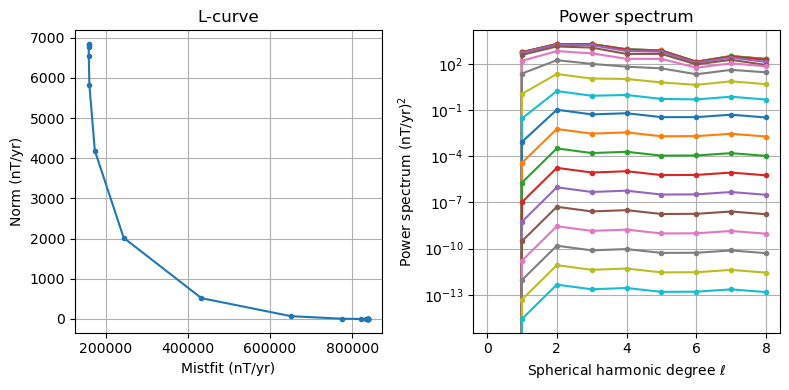

In [43]:
# Choose the radius of regularisation
radius_regularization = geomag.EARTH_RADIUS_KM

# Initialize the damping amount
lambdas = np.logspace(-2, 10, 20)
mistfits = np.zeros_like(lambdas)
norms = np.zeros_like(lambdas)
spectra = list()

# Compute the L-curve
for index, damping_amount in enumerate(lambdas):
    m_star = regularized_least_square(damping_amount, radius_regularization)
    residuals = observation - np.dot(forward, m_star)
    mistfit = residuals.T.dot(weight).dot(residuals)
    damping_matrix = geomag.damping_matrix(geomag.N_COEFFICIENTS, radius_regularization)
    norm = np.dot(np.dot(m_star.T, damping_matrix), m_star)
    mistfits[index] = mistfit
    norms[index] = norm
    spectra.append(geomag.compute_spectrum(damping_matrix, m_star))

# Prepare the figure
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the L-curve
ax[0].plot(mistfits, norms, ".-")
ax[0].set_xlabel("Mistfit (nT/yr)")
ax[0].set_ylabel("Norm (nT/yr)")
ax[0].grid()
ax[0].set_title("L-curve")

# Plot the spectrum
for spectrum in spectra:
    degrees = np.arange(len(spectrum))
    ax[1].semilogy(degrees, spectrum, ".-")
ax[1].set_xlabel("Spherical harmonic degree $\ell$")
ax[1].set_ylabel("Power spectrum (nT/yr)$^2$")
ax[1].grid()
ax[1].set_title("Power spectrum")

# Show
fig.tight_layout()
plt.show()

> **Question 20**: Traditionally, one chooses as a best model the best compromise between misfit and complexity (norm), by picking the $\lambda$ corresponding to the knee of the curve. Compute and represent the Z-component of the secular variation obtained with this model at the surface of the Earth and the surface of the core,  when the regularization is performed (ie the norm is computed) at the surface of the Earth. Is the distribution of residuals markedly different from the one you obtained in Question 12 ?

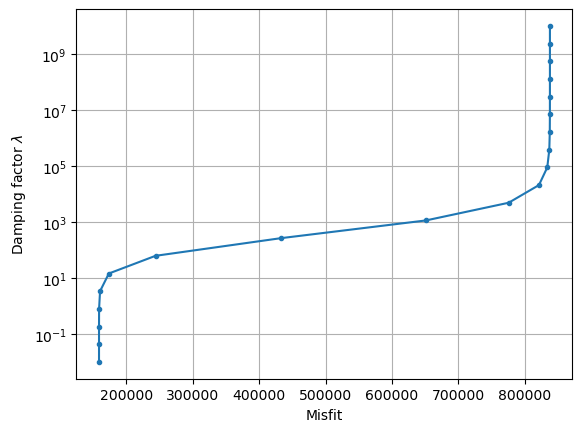

In [44]:
fig, ax = plt.subplots()
ax.semilogy(mistfits, lambdas, ".-")
ax.set_xlabel("Misfit")
ax.set_ylabel(r"Damping factor $\lambda$")
ax.grid()

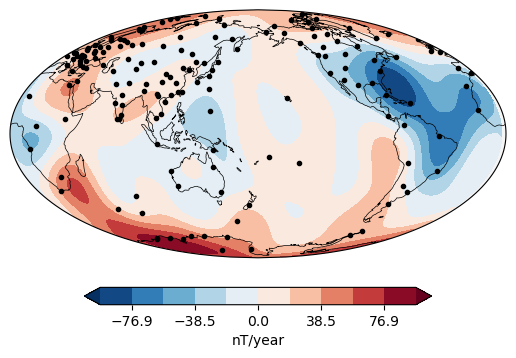

In [45]:
# Preferred lambda value
best_lambda = 100

# Preferred model
m_star = regularized_least_square(best_lambda, geomag.EARTH_RADIUS_KM)

# Forward matrix
forward_matrix = np.zeros((n_points, geomag.N_COEFFICIENTS))
for index, point in enumerate(grid):
    forward_matrix[index] = geomag.forward_matrix(*point, component="z")
best_field_z = np.dot(forward_matrix, m_star)

# Plot
ax = geomag.plot_field(colatitude, longitude, best_field_z)
geomag.plot(
    working_observatories.colatitude,
    working_observatories.longitude,
    ax=ax,
    marker=".",
    color="k",
    linestyle="none",
)

# Show
plt.show()

> **Question 24**: Repeat this exercise when the regularization is performed at the surface of the core ($r=3485$ km) or, in other words, when the matrix $\mathbf{D}$ entering the objective function is computed for $r=3485$ km. How is the spectrum of your preferred model different from the one obtained above? Propose an interpretation for the differences.


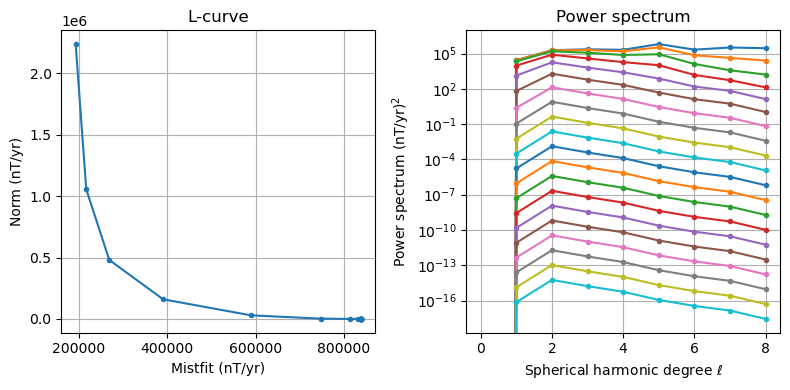

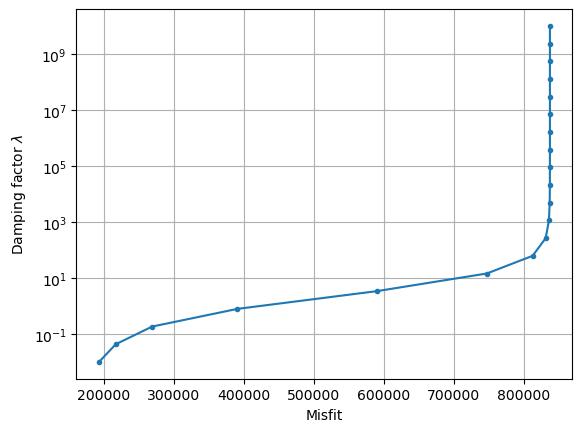

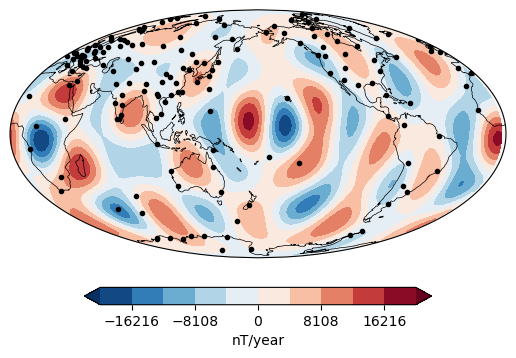

In [46]:
# Choose the radius of regularisation
radius_regularization = 3485.

# Initialize the damping amount
lambdas = np.logspace(-2, 10, 20)
mistfits = np.zeros_like(lambdas)
norms = np.zeros_like(lambdas)
spectra = list()

# Compute the L-curve
for index, damping_amount in enumerate(lambdas):
    m_star = regularized_least_square(damping_amount, radius_regularization)
    residuals = observation - np.dot(forward, m_star)
    mistfit = residuals.T.dot(weight).dot(residuals)
    damping_matrix = geomag.damping_matrix(geomag.N_COEFFICIENTS, radius_regularization)
    norm = np.dot(np.dot(m_star.T, damping_matrix), m_star)
    mistfits[index] = mistfit
    norms[index] = norm
    spectra.append(geomag.compute_spectrum(damping_matrix, m_star))

# Prepare the figure
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot the L-curve
ax[0].plot(mistfits, norms, ".-")
ax[0].set_xlabel("Mistfit (nT/yr)")
ax[0].set_ylabel("Norm (nT/yr)")
ax[0].grid()
ax[0].set_title("L-curve")

# Plot the spectrum
for spectrum in spectra:
    degrees = np.arange(len(spectrum))
    ax[1].semilogy(degrees, spectrum, ".-")
ax[1].set_xlabel("Spherical harmonic degree $\ell$")
ax[1].set_ylabel("Power spectrum (nT/yr)$^2$")
ax[1].grid()
ax[1].set_title("Power spectrum")

# Show
fig.tight_layout()
plt.show()

# Lambda
fig, ax = plt.subplots()
ax.semilogy(mistfits, lambdas, ".-")
ax.set_xlabel("Misfit")
ax.set_ylabel(r"Damping factor $\lambda$")
ax.grid()

# Preferred lambda value
best_lambda = 1

# Preferred model
m_star = regularized_least_square(best_lambda, geomag.EARTH_RADIUS_KM)

# Forward matrix
forward_matrix = np.zeros((n_points, geomag.N_COEFFICIENTS))
for index, point in enumerate(grid_core):
    forward_matrix[index] = geomag.forward_matrix(*point, component="z")
best_field_z = np.dot(forward_matrix, m_star)

# Plot
ax = geomag.plot_field(colatitude, longitude, best_field_z)
geomag.plot(
    working_observatories.colatitude,
    working_observatories.longitude,
    ax=ax,
    marker=".",
    color="k",
    linestyle="none",
)

# Show
plt.show()

## 5. Adding the external field

A possibility to obtain a better fit to the data consists of adding the contribution of the external geomagnetic field to the secular variation, recall Equation (1) above. The module ${\tt SHmag\_wext.py}$ is an extension of ${\tt SHmag.py}$ which allows you to resort to a model vector of the form

\begin{equation}
\mathbf{m} \coloneqq \left(\dot{g}_1^0, \dot{g}_1^1, \dot{h}_1^1, \dot{g}_2^0, \dot{g}_2^1, 
                   \dot{h}_2^1, \dot{g}_2^2, \dot{h}_2^2, 
                  \dots, \dot{g}_L^L, \dot{h}_L^L, 
                  \dot{q}_1^0, \dot{q}_1^1, \dot{s}_1^1, \dot{q}_2^0, \dot{q}_2^1, 
                   \dot{s}_2^1, \dot{q}_2^2, \dot{s}_2^2, 
                  \dots, \dot{q}_{L_e}^{L_e}, \dot{s}_{L_e}^{L_e}
               \right)^\mathsf{T}. 
\end{equation}

In the following we will assume that $L=8$ (as before) and $L_e=1$ (we only retain the dipole component of the external field). Given the epoch that you are in charge of, your task is to produce a model of the secular variation regularized **at the surface of the core** for that epoch, based on the trade-off curve methodology discussed before. **Note that $\mathbf{D}$ should only act on the Gauss coefficients describing the internal field (the $\dot{g}_\ell^m$ and $\dot{h}_\ell^m$)**.

You are expected to produce a number of diagnostics to describe this model. These diagnostics should include (without being limited to):
 - the distribution of the residuals (and a comparison with the distribution obtained when the external field is not included in the parameterization - is there a specific component for which the improvement is really substantial?)
 - a discussion of the presence of outliers in your dataset (as evidenced by the residual distribution), the observatory where the anomalous data originate from, etc.
 - a discussion of the map obtained at the surface of the core, concerning in particular the localization of the secular variation (ie places at the surface of the core where it would be stronger than in other places) 
 - the spectrum of your preferred model at the surface of the core.
